In [ ]:
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, MaxPooling1D, Conv2D, BatchNormalization, Dropout, SpatialDropout1D, Embedding, Conv1D, LSTM
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
import pandas as pd 
from PIL import Image 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов

import os 
import time

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_train = pd.read_csv('/content/train.csv')

In [ ]:
df_test

,Unnamed: 0,Smiles
0,0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...
...,...,...
1609,1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O
1610,1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1
1611,1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...
1612,1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1


In [ ]:
df_train

,Unnamed: 0,Smiles,Active
0,0,COc1ccc2[nH]cc(CCN)c2c1,False
1,1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False
...,...,...,...
5552,5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,False
5553,5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,False
5554,5554,Oc1cccc2cccnc12,False
5555,5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,False


In [ ]:
# оцениваю на пропуски
df_train.isna().sum()

Unnamed: 0    0
Smiles        0
Active        0
dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5557 non-null   int64 
 1   Smiles      5557 non-null   object
 2   Active      5557 non-null   bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 92.4+ KB


In [ ]:
df_train.describe()

,Unnamed: 0
count,5557.000000
mean,2778.000000
std,1604.312054
min,0.000000
25%,1389.000000
50%,2778.000000
75%,4167.000000
max,5556.000000


#Автокодировщик

**Представляю Smiles в виде вектора**

In [ ]:
!pip install kora -q
import kora.install.rdkit # по-дургому не запускалось
from rdkit import Chem
from rdkit.Chem import AllChem

     |████████████████████████████████| 57 kB 2.5 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 


In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]
df_train_True.head()

,Smiles,Active
17,Nc1ccc(O)c2ncccc12,True
38,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,True
52,Cl.NCCc1cc(O)c(O)cc1O,True
111,Cc1ccc(-n2sc(=O)n(Cc3ccc(F)cc3)c2=O)cc1,True
122,Oc1cc2c(cc1C(c1ccc(C(F)(F)F)cc1)N1CCOCC1)OCO2,True


In [ ]:
# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]
df_train_False.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
l = []
for i in s_inactive:
  l.append(len(i))
print(max(l), min(l))


598 6


In [ ]:
# самая длинная молекула
for i in s_inactive:
  if len(i)== 598:
    print(i)

C=C(NC(=O)[C@@H](NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H]1CS[C@@H](C)[C@H]2NC(=O)C(=C)NC(=O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]3CS[C@@H](C)[C@@H](NC(=O)[C@H](CCCNN)NC(=O)[C@@H]4CS[C@@H](C)[C@@H](NC(=O)[C@@H]5CSC[C@@H](NC(=O)/C(=C\C)NC(=O)[C@@H](N)[C@@H](C)CC)C(=O)N[C@@H]([C@@H](C)CC)C(=O)NC(=C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N5)C(=O)N5CCC[C@H]5C(=O)NCC(=O)N4)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCSC)C(=O)NCC(=O)N3)[C@H](C)SC[C@H](NC2=O)C(=O)N[C@H](Cc2cnc[nH]2)C(=O)N1)[C@@H](C)CC)C(C)C)C(=O)N[C@@H](CCCCN)C(=O)O


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
l = []
for i in s_active:
  l.append(len(i))
print(max(l), min(l))

262 14


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=4096): # сделал nBits=4096
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример вектора smal_active: {smal_active[77]}')
print(f'Размер массива smal_active: {smal_active.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 4096
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_active: (206, 4096)


In [ ]:
# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример вектора smal_active: {smal_inactive[77]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

In [ ]:
# смотрю максимальные и минимальные значения
smal_inactive.max(), smal_inactive.min(), 

(1, 0)

In [ ]:
RANDOM_SEED = 42 # задаем случайное значение

# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(smal_inactive, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# размеры
X_train.shape, X_test.shape, smal_active.shape

((4280, 4096), (1071, 4096), (206, 4096))

In [ ]:
'''
# создаю Y_test для тестовой и Y_smal_active для активных молекул
Y_test = np.zeros(1071)
Y_smal_active = np.ones(206)

# размеры
Y_test.shape, Y_smal_active.shape
'''

((1071,), (206,))

In [ ]:
# Добавляю все активные молекулы в тестовый набор данных для того, чтобы потом сравнивать mse после обучения
X_test = np.concatenate((X_test, smal_active))
Y_test = np.concatenate((Y_test, Y_smal_active))

# размеры
X_test.shape, Y_test.shape

**Нейронная сеть**

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 2s 3ms/step - loss: 0.1992
Epoch 2/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0630
Epoch 3/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0261
Epoch 4/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0175
Epoch 5/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0143
Epoch 6/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0127
Epoch 7/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 8/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0111
Epoch 9/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0107
Epoch 10/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0104
Epoch 11/100
357/357 [==============================] - 1s 4ms/step - loss: 0.0102
Epoch 12/100
357/357 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 13/100


**Проверка результата**

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
predictions.shape

(1277, 4096)

In [ ]:
predictions[9]

array([1.0093013e-04, 4.3236741e-05, 2.3633594e-02, ..., 2.5005715e-05,
       2.5241254e-05, 2.0602742e-05], dtype=float32)

In [ ]:
# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

In [ ]:
mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.001
Максимальная ошибка неактивных молекул: 0.0198
Средняя ошибка неактивных молекул: 0.0074242


In [ ]:
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка активных молекул: 0.0023
Максимальная ошибка активных молекул: 0.0203
Средняя ошибка активных молекул: 0.00701959


Я рассчитывал на то, что mse будет больше на активных молекулах, на которых сеть НЕ обучалась. Но по факту средняя ошибка на активных молекулах получилась практически одинаковая, чуть меньше. Активные => 0.0070, а неактивные => 0.0074

In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_Inactivel > bias # если ошибка больше порога - то неактивная
  isActive = mse_Active < bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.007)

Распознано неактивных молекул: 51%
Распознано активных молекул: 54%
Средняя точность распознавания: 53%


## Submit

In [ ]:
df_test = pd.read_csv('/content/test.csv', index_col = 0)
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [ ]:
# test
test_smiles = []
for i in df_test['Smiles']:
  test_smiles.append(i)

print('Длинна test_smiles:', len(test_smiles))
print("Пример значения из test_smiles:", test_smiles[1])

Длинна test_smiles: 1614
Пример значения из test_smiles: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12


In [ ]:
test = []
for i in test_smiles:
  sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
  test.append(sm)
test = np.array(test)             # преобразую в numpy
test.shape

(1614, 16384)

In [ ]:
predictions_test = model.predict(test) # делаем предсказание

In [ ]:
mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

Минимальная ошибка молекул: 0.0009
Максимальная ошибка молекул: 0.9688
Средняя ошибка молекул: 0.35042097


In [ ]:
mse_test.shape

(1614,)

In [ ]:
# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(mse_test)):
  if mse_test[i] >= 0.7:
    submission['Active'].values[i] = 1
  else:
    submission['Active'].values[i] = 0

In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
# соберу в функцию

def submission(df_test, bias):

  test_smiles = []
  for i in df_test['Smiles']:
    test_smiles.append(i)

  test = []
  for i in test_smiles:
    sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
    test.append(sm)
  test = np.array(test)             # преобразую в numpy
  
  predictions_test = model.predict(test) # делаем предсказание
  
  mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

  # Формирую табличку 
  submission = df_test
  submission['Active'] = ''
  
  for i in range(len(mse_test)):
    if mse_test[i] >= bias:
      submission['Active'].values[i] = 0
    else:
      submission['Active'].values[i] = 1
  
  submission.to_csv('submission.csv', index=False)

   
  print('Длинна test_smiles:', len(test_smiles))
  print("Пример значения из test_smiles:", test_smiles[1])
  print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
  print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
  print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

  return submission


##**Свертка Conv2D + Dense**

In [ ]:
X_train.shape, X_test.shape, smal_active.shape

((4280, 1024), (1277, 1024), (206, 1024))

In [ ]:
def Autoencoder_Conv2D(): 
    img_input = Input(shape=(1024,)) 

    x = Reshape((32,32,1))(img_input)

    x = Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x) # сплющиваем в одномерный вектор - размер 4*4*256
    z = Dense(256, activation='relu')(x) # добавляем полносвязный слой
    x = Dense(4*4*256, activation='relu')(z) # и еще полносвязный слой
    x = Reshape((4,4,256))(x) # меняем размеры - картинка 4*4 , 256 ядер
    x = Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x) 
    x = Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x) 
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(x) 
    x = Flatten()(x) # выпрямляю в вектор

    x = Dense(1024, activation='sigmoid')(x) # последний слой

    model = Model(img_input, x) 
    model.compile(optimizer='adam',
                  loss='mse') 

    return model 

In [ ]:
model_Conv2D = Autoencoder_Conv2D()
model_Conv2D.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 1024)              0   

In [ ]:
model_Conv2D = Autoencoder_Conv2D()

history = model_Conv2D.fit(X_train, X_train, epochs=10, batch_size=16) 

Epoch 1/10
268/268 [==============================] - 18s 22ms/step - loss: 0.2192
Epoch 2/10
268/268 [==============================] - 6s 21ms/step - loss: 0.1665
Epoch 3/10
268/268 [==============================] - 6s 21ms/step - loss: 0.1265
Epoch 4/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0969
Epoch 5/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0753
Epoch 6/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0594
Epoch 7/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0476
Epoch 8/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0387
Epoch 9/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0320
Epoch 10/10
268/268 [==============================] - 6s 21ms/step - loss: 0.0267


**Проверка**

In [ ]:
predictions = model_Conv2D.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
predictions.shape

(1277, 1024)

In [ ]:
# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0227
Максимальная ошибка неактивных молекул: 0.0314
Средняя ошибка неактивных молекул: 0.02456381

Минимальная ошибка активных молекул: 0.0227
Максимальная ошибка активных молекул: 0.0284
Средняя ошибка активных молекул: 0.02491298


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_Inactivel < bias # если ошибка больше порога - то неактивная
  isActive = mse_Active > bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.0249)

Распознано неактивных молекул: 65%
Распознано активных молекул: 46%
Средняя точность распознавания: 56%


##**По-другому токенезирую, Bag Of Words**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# все молекулы
Smiles = s_active + s_inactive
len(Smiles)

5557

In [ ]:
maxWordsCount = 10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - токенизируем по словам (Если будет True - каждый символ будет рассматриваться как отдельный токен )
tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=False, split='', oov_token=None,   char_level=True)

tokenizer.fit_on_texts(Smiles) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:50]) # Посмотрим 10 самых часто встречающихся символов
print("Размер словаря", len(items)) # Длина словаря

[('c', 1), ('C', 2), ('(', 3), (')', 4), ('O', 5), ('1', 6), ('2', 7), ('=', 8), ('@', 9), ('N', 10), ('[', 11), (']', 12), ('H', 13), ('n', 14), ('3', 15), ('F', 16), ('4', 17), ('-', 18), ('l', 19), ('S', 20), ('/', 21), ('.', 22), ('5', 23), ('+', 24), ('s', 25), ('o', 26), ('#', 27), ('\\', 28), ('B', 29), ('r', 30), ('P', 31), ('I', 32), ('a', 33), ('6', 34), ('7', 35), ('A', 36), ('8', 37), ('i', 38), ('K', 39), ('Z', 40), ('g', 41), ('M', 42), ('L', 43), ('e', 44), ('9', 45)]
Размер словаря 45


In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
s_inactive_WordIndexes = tokenizer.texts_to_sequences(s_inactive) # тесты в индексы
s_active_WordIndexes = tokenizer.texts_to_sequences(s_active) # тесты в индексы

print("Взглянем на Smiles:")
print("Как в таблице:              ", s_inactive[1])
print("В виде последовательности индексов: ", s_inactive_WordIndexes[1], '\n')
len(s_inactive[1]), len(s_inactive_WordIndexes[1])

Взглянем на Smiles:
Как в таблице:               CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
В виде последовательности индексов:  [2, 2, 2, 10, 6, 2, 2, 2, 11, 2, 9, 13, 12, 3, 1, 7, 1, 1, 1, 1, 3, 5, 4, 1, 7, 4, 2, 6, 22, 2, 19] 



(31, 31)

In [ ]:
len(s_inactive), len(s_inactive_WordIndexes)

(5351, 5351)

In [ ]:
X_tr = tokenizer.sequences_to_matrix(s_inactive_WordIndexes)
smal_active = tokenizer.sequences_to_matrix(s_active_WordIndexes)

print(X_tr.shape, smal_active.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(X_tr[0][0:100]) # Фрагмент в виде Bag of Words

(5351, 10000) (206, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
X_tr.max()

1.0

In [ ]:
RANDOM_SEED = 42

# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test = train_test_split(X_tr, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
X_test = np.concatenate((X_test, smal_active))
X_test.shape

(1277, 1024)

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 100 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(dataSize, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse') # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 100)               1100      
                                                                 
Total params: 2,110
Trainable params: 2,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 3s 2ms/step - loss: 0.2266
Epoch 2/100
357/357 [==============================] - 1s 2ms/step - loss: 0.1495
Epoch 3/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0821
Epoch 4/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0537
Epoch 5/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0438
Epoch 6/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0396
Epoch 7/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0373
Epoch 8/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0355
Epoch 9/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0338
Epoch 10/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0324
Epoch 11/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0311
Epoch 12/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0301
Epoch 13/100


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, X_train,
                    epochs=10,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0054
Epoch 2/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 3/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0046
Epoch 4/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 5/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0041
Epoch 6/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0039
Epoch 7/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 8/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 9/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0036
Epoch 10/10
357/357 [==============================] - 1s 2ms/step - loss: 0.0035


In [ ]:
history = model.fit(X_train, X_train,
                    epochs=100,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 2/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0033
Epoch 3/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 4/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 5/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0031
Epoch 6/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 7/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 8/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0029
Epoch 9/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 10/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 11/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 12/100
357/357 [==============================] - 1s 2ms/step - loss: 0.0027
Epoch 13/100


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

history = model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 2/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 9/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 10/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 12/50
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 13/50
357/357 [====

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, X_train,
                    epochs=20,
                    batch_size=12) # загружаем данные в модель(X_train'ы) и обучаем

Epoch 1/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 2/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 4/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 5/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 6/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 7/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 8/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 9/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 10/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 11/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 12/20
357/357 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 13/20
357/357 [====

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions.shape)

# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:1071] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[1071:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(1277, 100)
(1071,)
(206,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0
Максимальная ошибка неактивных молекул: 0.0565
Средняя ошибка неактивных молекул: 0.00135621

Минимальная ошибка активных молекул: 0.0
Максимальная ошибка активных молекул: 0.0663
Средняя ошибка активных молекул: 0.00409747


In [ ]:
def getAccByBias(bias): 
  isInactive = mse_Inactivel < bias # тут поменял знаки, так как mse неактивных меньше
  isActive = mse_Active > bias # поменял знаки

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.0013)

Распознано неактивных молекул: 87%
Распознано активных молекул: 32%
Средняя точность распознавания: 59%


In [ ]:
# функцию submit

def submission(df_test, model, bias):

  test_smiles = []
  for i in df_test['Smiles']:
    test_smiles.append(i)

  test = []
  for i in test_smiles:
    sm = get_morgan_fingerprint(i)  # получаю вектор из smiles
    test.append(sm)
  test = np.array(test)             # преобразую в numpy
  
  predictions_test = model.predict(test) # делаем предсказание
  
  mse_test = np.mean(np.power(test - predictions_test, 2), axis=1)

  # Формирую табличку 
  submission = df_test
  submission['Active'] = ''
  
  for i in range(len(mse_test)):
    if mse_test[i] >= bias:
      submission['Active'].values[i] = 0
    else:
      submission['Active'].values[i] = 1
  
  submission.to_csv('submission.csv', index=False)

   
  print('Длинна test_smiles:', len(test_smiles))
  print("Пример значения из test_smiles:", test_smiles[1])
  print("Минимальная ошибка молекул:", round(min(mse_test),4)) #
  print("Максимальная ошибка молекул:", round(max(mse_test),4)) #
  print("Средняя ошибка молекул:", round(sum(mse_test) / len(mse_test),8)) # среднюю ошибку

  return submission

In [ ]:
df_test = pd.read_csv('/content/test.csv', index_col = 0)
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [ ]:
submission = submission(df_test, model, 0.00031)

Длинна test_smiles: 1614
Пример значения из test_smiles: O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
Минимальная ошибка молекул: 0.0058
Максимальная ошибка молекул: 0.0805
Средняя ошибка молекул: 0.03111169


In [ ]:
submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,0
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


#**Классификация на маленькой выборке**

**Всего по 206 примеров**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]
# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=1, nBits=16384):
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример вектора smal_active: {smal_active[77]}')
print(f'Размер массива smal_active: {smal_active.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 16384
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_active: (206, 16384)


In [ ]:
# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример вектора smal_active: {smal_inactive[77]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 16384
Пример вектора smal_active: [0 0 0 ... 0 0 0]
Размер массива smal_inactive: (5351, 16384)


In [ ]:
smal_i = np.random.choice(5351, 206, replace = False)
smal_inactive = smal_inactive[smal_i]

In [ ]:
Y_active = np.ones(206,)
Y_active.shape

(206,)

In [ ]:
Y_inactive = np.zeros(206,)
Y_inactive.shape

(206,)

In [ ]:
X_tr = np.concatenate((smal_inactive, smal_active))
Y_tr = np.concatenate((Y_inactive, Y_active))
X_tr.shape, Y_tr.shape

((412, 16384), (412,))

In [ ]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_tr, Y_tr, test_size=0.05, shuffle=True) #shuffle=True - перемешиваем
X_train_1.shape, X_test_1.shape, Y_train_1.shape, Y_test_1.shape

((391, 16384), (21, 16384), (391,), (21,))

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_1, Y_train_1, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((351, 16384), (40, 16384), (351,), (40,))

In [ ]:
def Model_cl(): 
  dataSize = 16384 # размер входного слоя
  dataInput = Input(shape=(dataSize)) 
  
  x = Dense(99, activation='relu')(dataInput) 
  x = BatchNormalization()(x)
  x = Dropout(0.7) (x)
  x = Dense(13, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dropout(0.1) (x)
  x = Dense(7, activation='relu') (x)
  x = BatchNormalization()(x)
  x = Dense(1, activation='sigmoid')(x) 
  
  model = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
  
  return model

In [ ]:
model.summary()

Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 16384)]           0         
                                                                 
 dense_175 (Dense)           (None, 99)                1622115   
                                                                 
 batch_normalization_70 (Bat  (None, 99)               396       
 chNormalization)                                                
                                                                 
 dropout_66 (Dropout)        (None, 99)                0         
                                                                 
 dense_176 (Dense)           (None, 13)                1300      
                                                                 
 batch_normalization_71 (Bat  (None, 13)               52        
 chNormalization)                                         

Epoch 1/100
22/22 [==============================] - 2s 31ms/step - loss: 0.9252 - accuracy: 0.5328 - val_loss: 0.6850 - val_accuracy: 0.5500
Epoch 2/100
22/22 [==============================] - 0s 9ms/step - loss: 0.8685 - accuracy: 0.5641 - val_loss: 0.6969 - val_accuracy: 0.5250
Epoch 3/100
22/22 [==============================] - 0s 15ms/step - loss: 0.8326 - accuracy: 0.5413 - val_loss: 0.7168 - val_accuracy: 0.5250
Epoch 4/100
22/22 [==============================] - 0s 12ms/step - loss: 0.8295 - accuracy: 0.5670 - val_loss: 0.7357 - val_accuracy: 0.5250
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.7043 - accuracy: 0.6382 - val_loss: 0.7548 - val_accuracy: 0.5250
Epoch 6/100
22/22 [==============================] - 0s 11ms/step - loss: 0.6888 - accuracy: 0.6353 - val_loss: 0.7701 - val_accuracy: 0.5250
Epoch 7/100
22/22 [==============================] - 0s 16ms/step - loss: 0.6725 - accuracy: 0.6439 - val_loss: 0.7820 - val_accuracy: 0.5250
Epoch 8

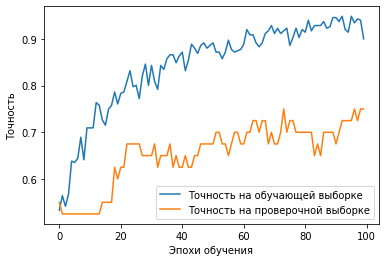

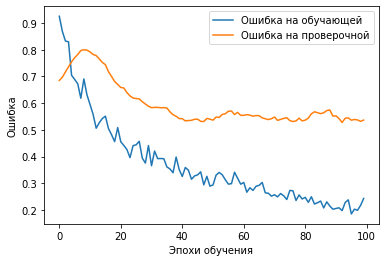

In [ ]:
model = Model_cl()

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=16,    # Размер батча
          epochs=100,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/100
22/22 [==============================] - 2s 19ms/step - loss: 0.2116 - accuracy: 0.9345 - val_loss: 0.5372 - val_accuracy: 0.7500
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 0.1929 - accuracy: 0.9402 - val_loss: 0.5381 - val_accuracy: 0.7500
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 0.1913 - accuracy: 0.9316 - val_loss: 0.5400 - val_accuracy: 0.7500
Epoch 4/100
22/22 [==============================] - 0s 10ms/step - loss: 0.2385 - accuracy: 0.9145 - val_loss: 0.5412 - val_accuracy: 0.7500
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 0.2081 - accuracy: 0.9430 - val_loss: 0.5416 - val_accuracy: 0.7500
Epoch 6/100
22/22 [==============================] - 0s 9ms/step - loss: 0.2001 - accuracy: 0.9459 - val_loss: 0.5441 - val_accuracy: 0.7500
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 0.2262 - accuracy: 0.9202 - val_loss: 0.5452 - val_accuracy: 0.7500
Epoch 8/

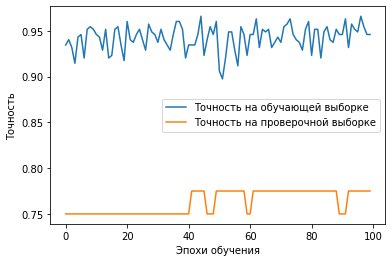

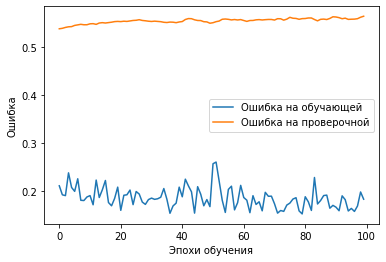

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=16,    # Размер батча
          epochs=100,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
# Вычисляем результаты сети на тестовом наборе
scores = model.evaluate(X_test_1, Y_test_1, verbose=1)

# scores состоит из двух знанчений
# scores[0] - loss сети на тестовой выборке
# scores[1] - процент правильно распознанных примеров на тестовой выборке
print(scores)
print("Доля верных ответов на тестовых данных, в процентах: ", round(scores[1] * 100, 4), "%", sep="")

1/1 [==============================] - 0s 28ms/step - loss: 0.4770 - accuracy: 0.8095
[0.47699660062789917, 0.8095238208770752]
Доля верных ответов на тестовых данных, в процентах: 80.9524%


In [ ]:
pred = model.predict(X_test_1)

In [ ]:
mse = np.mean(np.power(X_test_1 - pred, 2), axis=1) # определяем среднеквадратичную ошибку по X_test и предсказанием по X_test

In [ ]:
mse_IN = mse[Y_test_1 == 0] # среднеквадратичная ошибка на нормальных операциях
mse_AC = mse[Y_test_1 == 1] # среднеквадратичная ошибка на мошеннических операциях

In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_IN),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_IN),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_IN) / len(mse_IN),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0051
Максимальная ошибка неактивных молекул: 0.8616
Средняя ошибка неактивных молекул: 0.23753831


In [ ]:
print("Минимальная ошибка активных молекул:", round(min(mse_AC),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_AC),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_AC) / len(mse_AC),8)) # средняя ошибка

Минимальная ошибка активных молекул: 0.0161
Максимальная ошибка активных молекул: 0.9512
Средняя ошибка активных молекул: 0.70573876


In [ ]:
def getAccByBias(bias): # функция будет принимать какое то пороговое значение
  isInactive = mse_IN < bias # если ошибка больше порога - то неактивная
  isActive = mse_AC > bias # если ошибка меньше порога - то активная

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.7)

Распознано неактивных молекул: 86%
Распознано активных молекул: 79%
Средняя точность распознавания: 82%


**Пока это самый лучший результат из нейросетей.**

##Данные в Bag Of Words

In [ ]:
smal_inactive = tokenizer.sequences_to_matrix(s_inactive_WordIndexes)
smal_active = tokenizer.sequences_to_matrix(s_active_WordIndexes)

print(X_tr.shape, smal_active.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(X_tr[0][0:100]) # Фрагмент в виде Bag of Words

(5351, 10000) (206, 10000)
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
def Model_cl(): 
  dataSize = 10000 # размер входного слоя
  dataInput = Input(shape=(dataSize)) 
  
  x = Dense(3000, activation='relu')(dataInput) 
  #x = BatchNormalization()(x)
  x = Dropout(0.7) (x)
  x = BatchNormalization()(x)
  #x = Dense(3, activation='relu') (x)
  #x = BatchNormalization()(x)
  #x = Dropout(0.5) (x)
  x = Dense(2, activation='relu') (x)
  #x = BatchNormalization()(x)
  #x = Dropout(0.1) (x)
  x = Dense(1, activation='sigmoid')(x) 
  
  model = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
  
  return model

In [ ]:
model.summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 10000)]           0         
                                                                 
 dense_136 (Dense)           (None, 3000)              30003000  
                                                                 
 dropout_51 (Dropout)        (None, 3000)              0         
                                                                 
 batch_normalization_52 (Bat  (None, 3000)             12000     
 chNormalization)                                                
                                                                 
 dense_137 (Dense)           (None, 2)                 6002      
                                                                 
 dense_138 (Dense)           (None, 1)                 3         
                                                          

Epoch 1/50
8/8 [==============================] - 1s 51ms/step - loss: 0.7249 - accuracy: 0.4986 - val_loss: 0.6970 - val_accuracy: 0.3750
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.7058 - accuracy: 0.5385 - val_loss: 0.6965 - val_accuracy: 0.3750
Epoch 3/50
8/8 [==============================] - 0s 22ms/step - loss: 0.7030 - accuracy: 0.5299 - val_loss: 0.6961 - val_accuracy: 0.3750
Epoch 4/50
8/8 [==============================] - 0s 21ms/step - loss: 0.7406 - accuracy: 0.4587 - val_loss: 0.6956 - val_accuracy: 0.3750
Epoch 5/50
8/8 [==============================] - 0s 21ms/step - loss: 0.7077 - accuracy: 0.5328 - val_loss: 0.6951 - val_accuracy: 0.3750
Epoch 6/50
8/8 [==============================] - 0s 21ms/step - loss: 0.6984 - accuracy: 0.5698 - val_loss: 0.6946 - val_accuracy: 0.4250
Epoch 7/50
8/8 [==============================] - 0s 21ms/step - loss: 0.7234 - accuracy: 0.5299 - val_loss: 0.6942 - val_accuracy: 0.4500
Epoch 8/50
8/8 [===========

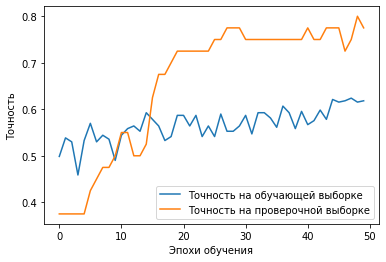

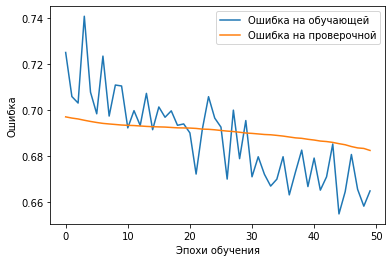

In [ ]:
model = Model_cl()

# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=50,    # Размер батча
          epochs=50,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Epoch 1/50
30/30 [==============================] - 3s 34ms/step - loss: 0.6421 - accuracy: 0.6524 - val_loss: 0.6063 - val_accuracy: 0.6750
Epoch 2/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6443 - accuracy: 0.6268 - val_loss: 0.6093 - val_accuracy: 0.6750
Epoch 3/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6528 - accuracy: 0.6325 - val_loss: 0.6106 - val_accuracy: 0.6750
Epoch 4/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6886 - accuracy: 0.6211 - val_loss: 0.6101 - val_accuracy: 0.7000
Epoch 5/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6537 - accuracy: 0.6581 - val_loss: 0.6121 - val_accuracy: 0.7000
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.5967 - accuracy: 0.6752 - val_loss: 0.6134 - val_accuracy: 0.7000
Epoch 7/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6313 - accuracy: 0.6439 - val_loss: 0.6104 - val_accuracy: 0.7000
Epoch 8/50
30

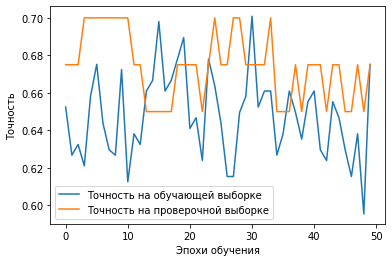

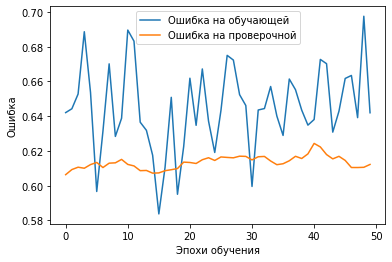

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])
# Обучаем сеть
history = model.fit(X_train,         
          Y_train,         
          batch_size=12,    # Размер батча
          epochs=50,        # Количество эпох
          validation_data= (X_test, Y_test),
          verbose=1)        # Выводить процесс обучения на каждой эпохе

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

#**Embedding**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]

In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl


In [ ]:
l = []
for i in s_inactive:
  l.append(len(i))
print(max(l), min(l))


598 6


In [ ]:
# самая длинная молекула
for i in s_inactive:
  if len(i) == 598:
    print(i)

C=C(NC(=O)[C@@H](NC(=O)[C@H](Cc1cnc[nH]1)NC(=O)[C@@H](NC(=O)[C@H](CO)NC(=O)[C@@H]1CS[C@@H](C)[C@H]2NC(=O)C(=C)NC(=O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](CCSC)NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H]3CS[C@@H](C)[C@@H](NC(=O)[C@H](CCCNN)NC(=O)[C@@H]4CS[C@@H](C)[C@@H](NC(=O)[C@@H]5CSC[C@@H](NC(=O)/C(=C\C)NC(=O)[C@@H](N)[C@@H](C)CC)C(=O)N[C@@H]([C@@H](C)CC)C(=O)NC(=C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N5)C(=O)N5CCC[C@H]5C(=O)NCC(=O)N4)C(=O)NCC(=O)N[C@@H](C)C(=O)N[C@@H]([C@@H](C)CC)C(=O)N[C@@H](CCSC)C(=O)NCC(=O)N3)[C@H](C)SC[C@H](NC2=O)C(=O)N[C@H](Cc2cnc[nH]2)C(=O)N1)[C@@H](C)CC)C(C)C)C(=O)N[C@@H](CCCCN)C(=O)O


In [ ]:
# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# все молекулы
Smiles = s_active + s_inactive
len(Smiles)

5557

In [ ]:
maxWordsCount = 1024 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=False, split='', oov_token=None, char_level=True)

tokenizer.fit_on_texts(Smiles) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
s_inactive_WordIndexes = tokenizer.texts_to_sequences(s_inactive) # тесты в индексы
s_active_WordIndexes = tokenizer.texts_to_sequences(s_active) # тесты в индексы

print("Взглянем на Smiles:")
print("Как в таблице:              ", s_inactive[1])
print("В виде последовательности индексов: ", s_inactive_WordIndexes[1], '\n')
len(s_inactive[1]), len(s_inactive_WordIndexes[1])

Взглянем на Smiles:
Как в таблице:               CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl
В виде последовательности индексов:  [2, 2, 2, 10, 6, 2, 2, 2, 11, 2, 9, 13, 12, 3, 1, 7, 1, 1, 1, 1, 3, 5, 4, 1, 7, 4, 2, 6, 22, 2, 19] 



(31, 31)

In [ ]:
len(s_inactive[9]), len(s_inactive_WordIndexes[9])

(35, 35)

In [ ]:
# самая длинная молекула
for i in s_inactive_WordIndexes:
  if len(i) == 598:
    print(i)

[2, 8, 2, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 1, 6, 1, 14, 1, 11, 14, 13, 12, 6, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 5, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 6, 2, 20, 11, 2, 9, 9, 13, 12, 3, 2, 4, 11, 2, 9, 13, 12, 7, 10, 2, 3, 8, 5, 4, 2, 3, 8, 2, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 2, 2, 10, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 20, 2, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 3, 10, 4, 8, 5, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 15, 2, 20, 11, 2, 9, 9, 13, 12, 3, 2, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 13, 12, 3, 2, 2, 2, 10, 10, 4, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 17, 2, 20, 11, 2, 9, 9, 13, 12, 3, 2, 4, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 11, 2, 9, 9, 13, 12, 23, 2, 20, 2, 11, 2, 9, 9, 13, 12, 3, 10, 2, 3, 8, 5, 4, 21, 2, 3, 8, 2, 28, 2, 4, 10, 2, 3, 8, 5, 4, 11, 

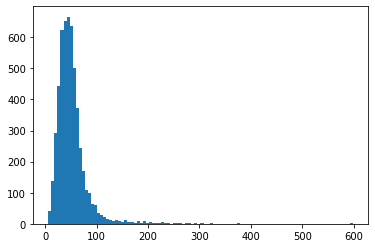

In [ ]:
lenXTrainE = [len(x) for x in s_inactive]
plt.hist(lenXTrainE, 100)
plt.show()

In [ ]:
maxlen = 600

xTrainE = pad_sequences(s_inactive_WordIndexes, maxlen=maxlen) #Преобразуем входные векторы
xActivE = pad_sequences(s_active_WordIndexes, maxlen=maxlen) #Преобразуем входные векторы

In [ ]:
print(xTrainE.shape, xActivE.shape)

(5351, 600) (206, 600)


In [ ]:
Y_tr = np.zeros(5351)
print(Y_tr.shape)
print(Y_tr[9])

(5351,)
0.0


In [ ]:
# берём неактивные молекулы разбиваем на train_test(только 'X')
X_train, X_test, Y_train, Y_test = train_test_split(xTrainE, Y_tr, test_size=0.04, shuffle=True) #shuffle=True - перемешиваем
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5136, 600), (5136,), (215, 600), (215,))

In [ ]:
X_train.max(), X_train.min()

(45, 0)

In [ ]:
#X_train, X_test_2, Y_train, Y_test_2 = train_test_split(X_t, Y_t, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем
#X_train.shape, Y_train.shape, X_test_2.shape, Y_test_2.shape

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 600 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) 
  
  x = Embedding(maxWordsCount, 20, input_length=maxlen) (dataInput)
  x = Dense(10, activation='relu')(x) 
  #x = Dense(20, activation='sigmoid')(x) #
  x = Flatten() (x)
  x = Dense(600, activation='relu')(x)

  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 600)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 600, 20)           20480     
                                                                 
 dense_22 (Dense)            (None, 600, 10)           210       
                                                                 
 flatten_11 (Flatten)        (None, 6000)              0         
                                                                 
 dense_23 (Dense)            (None, 600)               3600600   
                                                                 
Total params: 3,621,290
Trainable params: 3,621,290
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train, X_train,
                    epochs=50,
                    batch_size=12,
                    )

Epoch 1/50
428/428 [==============================] - 5s 9ms/step - loss: 2.6083
Epoch 2/50
428/428 [==============================] - 3s 7ms/step - loss: 0.6413
Epoch 3/50
428/428 [==============================] - 3s 7ms/step - loss: 0.3035
Epoch 4/50
428/428 [==============================] - 3s 7ms/step - loss: 0.2476
Epoch 5/50
428/428 [==============================] - 3s 7ms/step - loss: 0.2218
Epoch 6/50
428/428 [==============================] - 3s 7ms/step - loss: 0.2078
Epoch 7/50
428/428 [==============================] - 3s 7ms/step - loss: 0.2024
Epoch 8/50
428/428 [==============================] - 3s 7ms/step - loss: 0.1970
Epoch 9/50
428/428 [==============================] - 3s 7ms/step - loss: 0.1951
Epoch 10/50
428/428 [==============================] - 3s 7ms/step - loss: 0.1939
Epoch 11/50
428/428 [==============================] - 3s 7ms/step - loss: 0.1913
Epoch 12/50
428/428 [==============================] - 3s 7ms/step - loss: 0.1853
Epoch 13/50
428/428 [====

In [ ]:
X_test.shape, Y_test.shape

((215, 600), (215,))

In [ ]:
xActivE.shape

(206, 600)

In [ ]:
Y_test[22]

0.0

In [ ]:
X_test = np.concatenate((X_test, xActivE))
X_test.shape

(421, 600)

In [ ]:
predictions = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions.shape)

# считаю mse
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

mse_Inactivel = mse[:206] # неактивные. Так как при concatenate X_test и smal_activeдо 1071 были неактивные, а после 1071 активные.
mse_Active = mse[206:] # активные

# размеры
print(mse_Inactivel.shape)
print(mse_Active.shape)

(421, 600)
(206,)
(215,)


In [ ]:
print("Минимальная ошибка неактивных молекул:", round(min(mse_Inactivel),4)) #
print("Максимальная ошибка неактивных молекул:", round(max(mse_Inactivel),4)) #
print("Средняя ошибка неактивных молекул:", round(sum(mse_Inactivel) / len(mse_Inactivel),8)) # средняя ошибка
print()
print("Минимальная ошибка активных молекул:", round(min(mse_Active),4)) #
print("Максимальная ошибка активных молекул:", round(max(mse_Active),4)) #
print("Средняя ошибка активных молекул:", round(sum(mse_Active) / len(mse_Active),8)) # средняя ошибка

Минимальная ошибка неактивных молекул: 0.0002
Максимальная ошибка неактивных молекул: 11.6977
Средняя ошибка неактивных молекул: 0.1818317

Минимальная ошибка активных молекул: 0.0003
Максимальная ошибка активных молекул: 12.3277
Средняя ошибка активных молекул: 0.15677472


In [ ]:
def getAccByBias(bias): 
  isInactive = mse_Inactivel > bias # тут поменял знаки, так как mse неактивных меньше
  isActive = mse_Active < bias # поменял знаки

  accInactive = sum(isInactive) / len(isInactive) # вычисляем процент неактивных
  accActive = sum(isActive) / len(isActive) # вычисляем процент активных

  print("Распознано неактивных молекул: ", round(100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", round(100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", round(50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias(0.165)

Распознано неактивных молекул: 14%
Распознано активных молекул: 91%
Средняя точность распознавания: 52%


#**1 нейрон на выходе**

**Обучение на неактивных (INactive)**

In [ ]:
# загружаю датасет
df_train_new = pd.read_csv('/content/train.csv', index_col = 0)
df_train_new.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# df активные молекулы
df_train_True = df_train_new[df_train_new.Active==True]

# df неактивные молекулы
df_train_False = df_train_new[df_train_new.Active==False]
df_train_False.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
# собираю значения Smiles неактивных молекул в лист
s_inactive = []
for i in df_train_False['Smiles']:
  s_inactive.append(i)

print('Длинна s_inactive:', len(s_inactive))
print("Пример значения из s_inactive:", s_inactive[1])
print()

# активные молекулы
s_active = []
for i in df_train_True['Smiles']:
  s_active.append(i)

print('Длинна s_active:', len(s_active))
print("Пример значения из s_active:", s_active[1])

Длинна s_inactive: 5351
Пример значения из s_inactive: CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl

Длинна s_active: 206
Пример значения из s_active: C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23


In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=4096): # сделал nBits=4096
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример части вектора smal_active: {smal_active[77][:100]}')
print(f'Размер массива smal_active: {smal_active.shape}')
print()

# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример части вектора smal_active: {smal_inactive[77][:100]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')



Количество молекул активных: 206
Длинна вектора одной молекулы: 4096
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_active: (206, 4096)

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 4096
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_inactive: (5351, 4096)


In [ ]:
# смотрю максимальные и минимальные значения
smal_inactive.max(), smal_inactive.min(), 

(1, 0)

In [ ]:
# X_Train это наш smal_inactive
x_tr = smal_inactive

# ДЛя Y_Train создаю вектор из нулей
y_tr = np.zeros(x_tr.shape[0],)
x_tr.shape, y_tr.shape

((5351, 4096), (5351,))

In [ ]:
# разбиваю на выборки
X_train, X_test, Y_train, Y_test = train_test_split(x_tr, y_tr, test_size=0.04, shuffle=True) #shuffle=True - перемешиваем

# размеры
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((5136, 4096), (5136,), (215, 4096), (215,))

In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 4096 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(1, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_2 (Dense)             (None, 10)                40970     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 40,981
Trainable params: 40,981
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3397 - accuracy: 0.9807 - val_loss: 0.1392 - val_accuracy: 1.0000
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0896 - accuracy: 1.0000 - val_loss: 0.0550 - val_accuracy: 1.0000
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 0.0421 - accuracy: 1.0000 - val_loss: 0.0298 - val_accuracy: 1.0000
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0164 - accuracy: 1.0000 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 6/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000

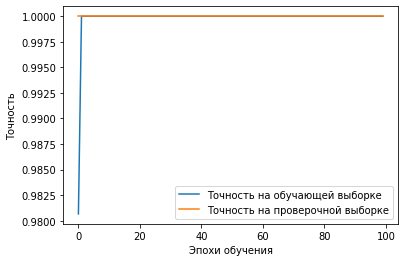

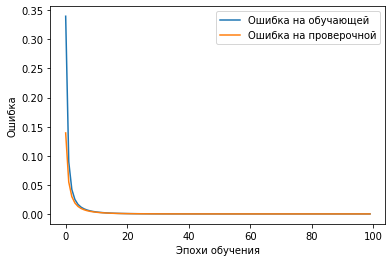

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train[:4500], Y_train[:4500],
                    epochs=100,
                    batch_size=12,
                    validation_data= (X_train[4500:], Y_train[4500:]), verbose=1
                    )

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Данные неактивных молекул, котоые сеть не видела

In [ ]:
# готовлю вектор для проверки на данных, которые сеть не видела

In [ ]:
predictions_IN = model.predict(X_test) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions_IN.shape)
predictions_IN[1]


(215, 1)


array([8.1603916e-16], dtype=float32)

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
Inactiv_pred = sum(predictions_IN)/len(predictions_IN)
print(predictions_IN.shape)
print(Inactiv_pred)

(215, 1)
[1.5070235e-08]


Данные активных молекул, которые сеть не видела

In [ ]:
predictions_AC = model.predict(smal_active) # делаем предсказание по X_test на неактивных и активных молекулах
print(predictions_AC.shape)
predictions_AC[1]

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
Activ_pred = sum(predictions_AC)/len(predictions_AC)
print(predictions_IN.shape)
print(Activ_pred)

(215, 1)
[3.766762e-08]


In [ ]:
# По значениям предикта попробую отличать активные молекулы от неактивных

In [ ]:
x_test_IN_AC = np.concatenate((X_test, smal_active))
x_test_IN_AC.shape

(421, 4096)

In [ ]:
(3.766762 * 10 ** -8) > (1.5070235 * 10 ** -8)

True

In [ ]:
def getAccByBias(bias): 
  In_pred = predictions_IN > bias 
  Ac_pred = predictions_AC < bias 

  accInactive = sum(In_pred) / len(In_pred)
  accActive = sum(Ac_pred) / len(Ac_pred) 

  print("Распознано неактивных молекул: ", (100*accInactive), "%", sep="")
  print("Распознано активных молекул: ", (100*accActive), "%", sep="")
  print("Средняя точность распознавания: ", (50*(accInactive + accActive)), "%", sep="")

In [ ]:
getAccByBias((3.766762 * 10 ** -8))

Распознано неактивных молекул: [98.60465116]%
Распознано активных молекул: [4.36893204]%
Средняя точность распознавания: [51.4867916]%


In [ ]:
predictions_test = model.predict(test) # делаем предсказание

In [ ]:
# Формирую табличку 
submission = df_test
submission['Active'] = ''

for i in range(len(predictions_test)):
  if i > (1.5070235 * 10 ** -8):
    submission['Active'].values[i] = True
  else:
    submission['Active'].values[i] = False

In [ ]:
submission.to_csv('submission.csv', index=False)

**Для активных**

In [ ]:
# функция перефода smiles в вектор 0 и 1
def get_morgan_fingerprint(smiles: str, radius=2, nBits=1024): # сделал nBits=1024
    mol = Chem.MolFromSmiles(smiles)
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    return (list(morgan_fp))

In [ ]:
# для активных
smal_active = []
for i in s_active:
  sm = get_morgan_fingerprint(i)      # получаю вектор из smiles
  smal_active.append(sm)
smal_active = np.array(smal_active)   # преобразую в numpy

print(f"Количество молекул активных: {len(smal_active)}\nДлинна вектора одной молекулы: {len(smal_active[77])}")
print(f'Пример части вектора smal_active: {smal_active[77][:100]}')
print(f'Размер массива smal_active: {smal_active.shape}')
print()

# для неактивных
smal_inactive = []
for i in s_inactive:
  sm = get_morgan_fingerprint(i)       # получаю вектор из smiles
  smal_inactive.append(sm)
smal_inactive = np.array(smal_inactive)# преобразую в numpy

print(f"Количество молекул не активных: {len(smal_inactive)}\nДлинна вектора одной молекулы: {len(smal_inactive[77])}")
print(f'Пример части вектора smal_active: {smal_inactive[77][:100]}')
print(f'Размер массива smal_inactive: {smal_inactive.shape}')

Количество молекул активных: 206
Длинна вектора одной молекулы: 1024
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_active: (206, 1024)

Количество молекул не активных: 5351
Длинна вектора одной молекулы: 1024
Пример части вектора smal_active: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Размер массива smal_inactive: (5351, 1024)


In [ ]:
# смотрю максимальные и минимальные значения
smal_active.max(), smal_active.min(), 

(1, 0)

In [ ]:
# X_Tr это наш smal_active
x_tr = smal_active

# ДЛя Y_Train создаю вектор из нулей
y_tr = np.ones(x_tr.shape[0],)
x_tr.shape, y_tr.shape

((206, 1024), (206,))

In [ ]:
# разбиваю на выборки
X_train, X_test, Y_train, Y_test = train_test_split(x_tr, y_tr, test_size=0.1, shuffle=True) #shuffle=True - перемешиваем

# размеры
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((185, 1024), (185,), (21, 1024), (21,))

In [ ]:
# рандомно выбираю 21 НЕактивную молекулы для будущего теста
smal_in = np.random.choice(5351, 21, replace = False)
smal_INactive = smal_inactive[smal_in]
y_inctive = np.zeros(21,)

print(smal_INactive.shape)

X_test = np.concatenate((X_test, smal_INactive))
print(X_test.shape)

Y_test = np.concatenate((Y_test, y_inctive))
print(Y_test.shape)

(21, 1024)
(42, 1024)
(42,)


In [ ]:
def Smiles_Autoencoder(): 
  dataSize = 1024 # размер входного слоя
  dataInput = Input(shape=(dataSize, )) # задаем эти размеры как входные в сеть
  
  x = Dense(10, activation='relu')(dataInput) # пропускаем через полносвязный слой размером 10
  x = Dense(1, activation='sigmoid')(x) # выход это полносвязный слой размером 4096
  
  autoencoder = Model(inputs=dataInput, outputs=x) # собрали модель 
  
  autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy']) # компилируем модель также, с выбором оптимайзера и среднеквадратичной ошибки
  
  return autoencoder 

In [ ]:
model = Smiles_Autoencoder()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_8 (Dense)             (None, 10)                10250     
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10,261
Trainable params: 10,261
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
29/29 [==============================] - 1s 10ms/step - loss: 0.5345 - accuracy: 0.9588 - val_loss: 0.5312 - val_accuracy: 1.0000
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.4751 - accuracy: 0.9941 - val_loss: 0.4768 - val_accuracy: 1.0000
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.4191 - accuracy: 1.0000 - val_loss: 0.4235 - val_accuracy: 1.0000
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3650 - accuracy: 1.0000 - val_loss: 0.3741 - val_accuracy: 1.0000
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.3157 - accuracy: 1.0000 - val_loss: 0.3300 - val_accuracy: 1.0000
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.2724 - accuracy: 1.0000 - val_loss: 0.2913 - val_accuracy: 1.0000
Epoch 7/100
29/29 [==============================] - 0s 4ms/step - loss: 0.2346 - accuracy: 1.0000 - val_loss: 0.2565 - val_accuracy: 1.0000
Epoch 8/100


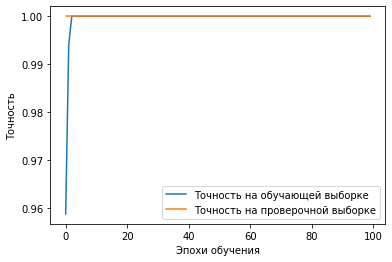

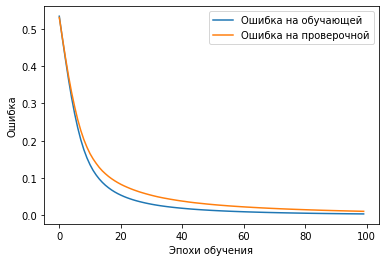

In [ ]:
model = Smiles_Autoencoder()
history = model.fit(X_train[:170], Y_train[:170],
                    epochs=100,
                    batch_size=6,
                    validation_data= (X_train[170:], Y_train[170:]), verbose=1
                    )

plt.plot(history.history['accuracy'], label='Точность на обучающей выборке')
plt.plot(history.history['val_accuracy'], label ='Точность на проверочной выборке')
plt.xlabel('Эпохи обучения')
plt.ylabel('Точность')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label ='Ошибка на обучающей')
plt.plot(history.history['val_loss'], label ='Ошибка на проверочной')
plt.xlabel('Эпохи обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


In [ ]:
predictions_AC = model.predict(X_test) 
print(predictions_AC.shape)
predictions_AC[1]

(42, 1)


array([0.9996915], dtype=float32)

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
Activ_pred = sum(predictions_AC)/len(predictions_AC)
print(predictions_AC.shape)
print(Activ_pred)

(42, 1)
[0.99313754]


In [ ]:
predictions_IN = model.predict(smal_INactive) 
print(predictions_IN.shape)
predictions_IN[1]


(21, 1)


array([0.9954562], dtype=float32)

In [ ]:
# считаю среднее значение на X_test - на данных которые сеть не видела, неактивные молекулы
INactiv_pred = sum(predictions_IN)/len(predictions_IN)
print(predictions_IN.shape)
print(INactiv_pred)

(21, 1)
[0.98834854]


#Составная нейронка с несколькими входами